In [1]:
import os,librosa
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from tqdm import tqdm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import optimizers as opt
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import losses
import pandas as pd
import seaborn as sns
import itertools
from sklearn.metrics import confusion_matrix
from matplotlib.font_manager import FontProperties

In [2]:
seed=42
n_MFCC=25
column_names= ['MFCC_'+str(i) for i in range(1,n_MFCC+1)]

In [3]:
DATA_PATH="/home/rakibul/WORK/Work/Thesis/Speech_Recognition/Vowel_Word/GitHub Repo/Vowel_Data/Vowel/"

In [4]:
def get_mfcc(file_path):
    wave, sr= librosa.load(file_path, mono=True, sr=None)
    mfcc=librosa.feature.mfcc(wave,sr=sr,n_mfcc=n_MFCC)
    mfcc_df=pd.DataFrame(mfcc.T,columns=column_names) #convert array to pandas df
    return mfcc_df

def get_all_mfcc(path=DATA_PATH):
    labels=sorted(os.listdir(path))
    all_mfcc=pd.DataFrame() #empty dataframe to store all_mfccs
    
    for label_index,label in enumerate(labels):
        folder_mfcc=pd.DataFrame() #empty dataframe to store mfcc of indivuals vowels/words i.e. folders

        speech_files=[path + label + '/' + file for file in sorted(os.listdir(path+'/'+label))]
        for file in tqdm(speech_files,"Reading Speech of label -'{}'".format(label)):
            #print(file)
            individual_mfcc=get_mfcc(file_path=file)
            folder_mfcc=folder_mfcc.append(individual_mfcc,ignore_index=True)
        
        folder_mfcc['label']=label_index  #new columns for encoding label
        
        all_mfcc=all_mfcc.append(folder_mfcc,ignore_index=True)
        
    return all_mfcc

def get_train_test(split_ratio=0.8,random_state=42):
    all_mfccs=get_all_mfcc()
    
    y=all_mfccs['label'].values
    
    only_mfcc=all_mfccs.drop(labels=['label'],axis=1)
    standard_mfcc=(only_mfcc-only_mfcc.mean())/only_mfcc.std()
    X=standard_mfcc.values

    assert X.shape[0] == len(y)
    return train_test_split(X,y,test_size=(1-split_ratio),random_state=random_state,shuffle=True,stratify=y)

prop=FontProperties()
prop.set_file('/home/rakibul/STUDY/Software/Windows/Fonts/Kalpurush.ttf')

def plot_cnf_mat(cm,classes,title,normalize=True): #Normalization can be avoided by setting normalize=False
    if normalize:
        cm=cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
        print('Normalized confusion matrix')
    else:
        print('Confusion matrix without normalization')
    
    print(cm)
    plt.figure(figsize=(10,9))
    plt.imshow(cm,interpolation='nearest',cmap=plt.cm.Blues)
    plt.title(title,fontsize=20)
    cbar=plt.colorbar()
    cbar.ax.tick_params(labelsize=18) 
    tick_marks=np.arange(len(classes))
    plt.xticks(tick_marks,classes,rotation=45,fontproperties=prop,fontsize=24)
    plt.yticks(tick_marks,classes,fontproperties=prop,fontsize=24)
    
    fmt='.2f' if normalize else 'd'
    thresh=cm.max()/2.
    for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j,i,format(cm[i,j],fmt),horizontalalignment="center",
                 color="white" if cm[i,j] > thresh else "black",fontsize=18)
    
    plt.xlabel('Predicted label',fontsize=20)
    plt.ylabel('True label',fontsize=20)
    plt.tight_layout()
    plt.savefig('/home/rakibul/WORK/Work/Thesis/Speech_Recognition/Vowel_Word/GitHub Repo/Result/New_without_CNN/'+title+'_MFCC.pdf',format='pdf', dpi=600)

In [5]:
np.random.seed(seed)

X_train, X_test, y_train, y_test=get_train_test()
y_train_hot=to_categorical(y_train)

model_v=Sequential()
model_v.add(Dense(128, activation='tanh',input_shape=(X_train.shape[1],)))
model_v.add(Dense(128, activation='tanh'))
model_v.add(Dense(64, activation='tanh'))
model_v.add(Dense(32, activation='tanh'))
model_v.add(Dense(16, activation='tanh'))
model_v.add(Dense(7, activation='softmax'))

model_v.compile(
    optimizer=opt.Adam(learning_rate=0.005),
    loss='categorical_crossentropy',
    metrics=['AUC']
)

model_v.fit(X_train, y_train_hot, epochs=300, batch_size=X_train.shape[0])
y_pred=model_v.predict_classes(X_test)

Reading Speech of label -'vowel7': 100%|██████████| 40/40 [00:00<00:00, 100.03it/s]


Epoch 1/300
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
1/1 [==============================] - 0s 2ms/step - loss: 2.0770 - auc: 0.4409
Epoch 2/300
1/1 [==============================] - 0s 3ms/step - loss: 1.5095 - auc: 0.8441
Epoch 3/300
1/1 [==============================] - 0s 3ms/step - loss: 1.2849 - auc: 0.9059
Epoch 4/300
1/1 [==============================] - 0s 2ms/step - loss: 1.1550 - auc: 0.9345
Epoch 5/300
1/1 [==============================] - 0s 1ms/step - loss: 1.0608 - auc: 0.9507
Epoch 6/300
1/1 [==============================] - 0s 2ms/step - loss: 0.9873 - auc: 0.9592
Epoch 7/300
1/1 [==============================] - 0s 3ms/step - loss: 0.9280 - auc: 0.9634
Epoch 8/300
1/1 [==============================] - 0s 3ms/step - loss: 0.8778 - auc: 0.9660
Epoch 9/300
1/1 [==============================] - 0s 1ms/step - loss: 0.8327 - auc: 0.9683
Epoch 10/300
1/1 [==============================] - 0s 1ms/step - loss: 0.7915 - auc: 0.970

1/1 [==============================] - 0s 3ms/step - loss: 0.0244 - auc: 1.0000
Epoch 86/300
1/1 [==============================] - 0s 3ms/step - loss: 0.0234 - auc: 1.0000
Epoch 87/300
1/1 [==============================] - 0s 3ms/step - loss: 0.0225 - auc: 1.0000
Epoch 88/300
1/1 [==============================] - 0s 2ms/step - loss: 0.0216 - auc: 1.0000
Epoch 89/300
1/1 [==============================] - 0s 1ms/step - loss: 0.0208 - auc: 1.0000
Epoch 90/300
1/1 [==============================] - 0s 2ms/step - loss: 0.0200 - auc: 1.0000
Epoch 91/300
1/1 [==============================] - 0s 2ms/step - loss: 0.0193 - auc: 1.0000
Epoch 92/300
1/1 [==============================] - 0s 4ms/step - loss: 0.0186 - auc: 1.0000
Epoch 93/300
1/1 [==============================] - 0s 2ms/step - loss: 0.0179 - auc: 1.0000
Epoch 94/300
1/1 [==============================] - 0s 2ms/step - loss: 0.0173 - auc: 1.0000
Epoch 95/300
1/1 [==============================] - 0s 2ms/step - loss: 0.0167 - au

1/1 [==============================] - 0s 2ms/step - loss: 0.0047 - auc: 1.0000
Epoch 173/300
1/1 [==============================] - 0s 2ms/step - loss: 0.0047 - auc: 1.0000
Epoch 174/300
1/1 [==============================] - 0s 3ms/step - loss: 0.0046 - auc: 1.0000
Epoch 175/300
1/1 [==============================] - 0s 2ms/step - loss: 0.0046 - auc: 1.0000
Epoch 176/300
1/1 [==============================] - 0s 3ms/step - loss: 0.0045 - auc: 1.0000
Epoch 177/300
1/1 [==============================] - 0s 1ms/step - loss: 0.0045 - auc: 1.0000
Epoch 178/300
1/1 [==============================] - 0s 3ms/step - loss: 0.0045 - auc: 1.0000
Epoch 179/300
1/1 [==============================] - 0s 2ms/step - loss: 0.0044 - auc: 1.0000
Epoch 180/300
1/1 [==============================] - 0s 4ms/step - loss: 0.0044 - auc: 1.0000
Epoch 181/300
1/1 [==============================] - 0s 3ms/step - loss: 0.0043 - auc: 1.0000
Epoch 182/300
1/1 [==============================] - 0s 2ms/step - loss: 0

1/1 [==============================] - 0s 3ms/step - loss: 0.0025 - auc: 1.0000
Epoch 260/300
1/1 [==============================] - 0s 1ms/step - loss: 0.0025 - auc: 1.0000
Epoch 261/300
1/1 [==============================] - 0s 1ms/step - loss: 0.0025 - auc: 1.0000
Epoch 262/300
1/1 [==============================] - 0s 2ms/step - loss: 0.0025 - auc: 1.0000
Epoch 263/300
1/1 [==============================] - 0s 1ms/step - loss: 0.0025 - auc: 1.0000
Epoch 264/300
1/1 [==============================] - 0s 2ms/step - loss: 0.0025 - auc: 1.0000
Epoch 265/300
1/1 [==============================] - 0s 3ms/step - loss: 0.0025 - auc: 1.0000
Epoch 266/300
1/1 [==============================] - 0s 2ms/step - loss: 0.0024 - auc: 1.0000
Epoch 267/300
1/1 [==============================] - 0s 2ms/step - loss: 0.0024 - auc: 1.0000
Epoch 268/300
1/1 [==============================] - 0s 1ms/step - loss: 0.0024 - auc: 1.0000
Epoch 269/300
1/1 [==============================] - 0s 4ms/step - loss: 0

Normalized confusion matrix
[[1.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.99 0.   0.   0.   0.   0.  ]
 [0.   0.   0.96 0.   0.01 0.   0.03]
 [0.   0.   0.   0.99 0.   0.   0.  ]
 [0.   0.   0.01 0.   0.97 0.01 0.02]
 [0.   0.   0.   0.   0.   1.   0.  ]
 [0.   0.   0.   0.   0.   0.01 0.99]]


<Figure size 432x288 with 0 Axes>

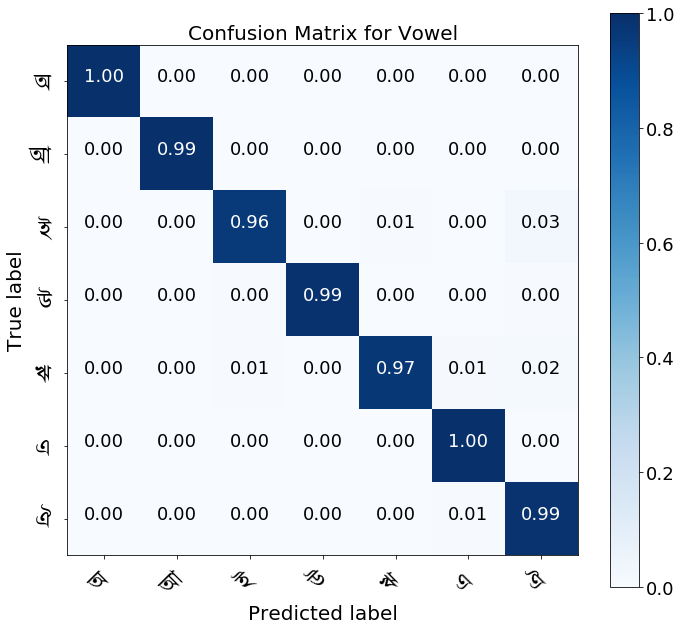

In [6]:
class_names=['অ ','আ ','ই ','উ ','ঋ ','এ ','ঐ ']
cnf_matrix=confusion_matrix(y_test,y_pred)
np.set_printoptions(precision=2)
plt.figure()
plot_cnf_mat(cnf_matrix,classes=class_names,title='Confusion Matrix for Vowel')
plt.show()

In [7]:
DATA_PATH="/home/rakibul/WORK/Work/Thesis/Speech_Recognition/Vowel_Word/GitHub Repo/Word_Data/Word/"

In [8]:
def get_mfcc(file_path):
    wave, sr= librosa.load(file_path, mono=True, sr=None)
    mfcc=librosa.feature.mfcc(wave,sr=sr,n_mfcc=n_MFCC)
    mfcc_df=pd.DataFrame(mfcc.T,columns=column_names) #convert array to pandas df
    return mfcc_df

def get_all_mfcc(path=DATA_PATH):
    labels=sorted(os.listdir(path))
    all_mfcc=pd.DataFrame() #empty dataframe to store all_mfccs
    
    for label_index,label in enumerate(labels):
        folder_mfcc=pd.DataFrame() #empty dataframe to store mfcc of indivuals vowels/words i.e. folders

        speech_files=[path + label + '/' + file for file in sorted(os.listdir(path+'/'+label))]
        for file in tqdm(speech_files,"Reading Speech of label -'{}'".format(label)):
            #print(file)
            individual_mfcc=get_mfcc(file_path=file)
            folder_mfcc=folder_mfcc.append(individual_mfcc,ignore_index=True)
        
        folder_mfcc['label']=label_index  #new columns for encoding label
        
        all_mfcc=all_mfcc.append(folder_mfcc,ignore_index=True)
        
    return all_mfcc

def get_train_test(split_ratio=0.8,random_state=42):
    all_mfccs=get_all_mfcc()
    
    y=all_mfccs['label'].values
    
    only_mfcc=all_mfccs.drop(labels=['label'],axis=1)
    standard_mfcc=(only_mfcc-only_mfcc.mean())/only_mfcc.std()
    X=standard_mfcc.values

    assert X.shape[0] == len(y)
    return train_test_split(X,y,test_size=(1-split_ratio),random_state=random_state,shuffle=True,stratify=y)

prop=FontProperties()
prop.set_file('/home/rakibul/STUDY/Software/Windows/Fonts/Kalpurush.ttf')

def plot_cnf_mat(cm,classes,title,normalize=True): #Normalization can be avoided by setting normalize=False
    if normalize:
        cm=cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
        print('Normalized confusion matrix')
    else:
        print('Confusion matrix without normalization')
    
    print(cm)
    plt.figure(figsize=(10,9))
    plt.imshow(cm,interpolation='nearest',cmap=plt.cm.Blues)
    plt.title(title,fontsize=20)
    cbar=plt.colorbar()
    cbar.ax.tick_params(labelsize=18) 
    tick_marks=np.arange(len(classes))
    plt.xticks(tick_marks,classes,rotation=45,fontproperties=prop,fontsize=24)
    plt.yticks(tick_marks,classes,fontproperties=prop,fontsize=24)
    
    fmt='.2f' if normalize else 'd'
    thresh=cm.max()/2.
    for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j,i,format(cm[i,j],fmt),horizontalalignment="center",
                 color="white" if cm[i,j] > thresh else "black",fontsize=18)
    
    plt.xlabel('Predicted label',fontsize=20)
    plt.ylabel('True label',fontsize=20)
    plt.tight_layout()
    plt.savefig('/home/rakibul/WORK/Work/Thesis/Speech_Recognition/Vowel_Word/GitHub Repo/Result/New_without_CNN/'+title+'_MFCC.pdf',format='pdf', dpi=600)

In [9]:
np.random.seed(seed)

X_train, X_test, y_train, y_test=get_train_test()
y_train_hot=to_categorical(y_train)

model_w=Sequential()
model_w.add(Dense(256, activation='tanh',input_shape=(X_train.shape[1],)))
model_w.add(Dense(128, activation='tanh'))
model_w.add(Dense(64, activation='tanh'))
model_w.add(Dense(32, activation='tanh'))
model_w.add(Dense(16, activation='tanh'))
model_w.add(Dense(7, activation='softmax'))

model_w.compile(
    optimizer=opt.Adam(learning_rate=0.005),
    loss='categorical_crossentropy',
    metrics=['AUC']
)

model_w.fit(X_train, y_train_hot, epochs=300, batch_size=X_train.shape[0])
y_pred=model_w.predict_classes(X_test)

Reading Speech of label -'Word7': 100%|██████████| 40/40 [00:00<00:00, 103.84it/s]


Epoch 1/300
1/1 [==============================] - 0s 1ms/step - loss: 1.9838 - auc: 0.5448
Epoch 2/300
1/1 [==============================] - 0s 2ms/step - loss: 1.5220 - auc: 0.8006
Epoch 3/300
1/1 [==============================] - 0s 3ms/step - loss: 1.4314 - auc: 0.8237
Epoch 4/300
1/1 [==============================] - 0s 2ms/step - loss: 1.3824 - auc: 0.8359
Epoch 5/300
1/1 [==============================] - 0s 1ms/step - loss: 1.3431 - auc: 0.8456
Epoch 6/300
1/1 [==============================] - 0s 2ms/step - loss: 1.3109 - auc: 0.8535
Epoch 7/300
1/1 [==============================] - 0s 1ms/step - loss: 1.2853 - auc: 0.8601
Epoch 8/300
1/1 [==============================] - 0s 2ms/step - loss: 1.2632 - auc: 0.8658
Epoch 9/300
1/1 [==============================] - 0s 3ms/step - loss: 1.2428 - auc: 0.8711
Epoch 10/300
1/1 [==============================] - 0s 1ms/step - loss: 1.2239 - auc: 0.8759
Epoch 11/300
1/1 [==============================] - 0s 4ms/step - loss: 1.2064 

1/1 [==============================] - 0s 2ms/step - loss: 0.1202 - auc: 0.9993
Epoch 90/300
1/1 [==============================] - 0s 1ms/step - loss: 0.1205 - auc: 0.9993
Epoch 91/300
1/1 [==============================] - 0s 1ms/step - loss: 0.1134 - auc: 0.9993
Epoch 92/300
1/1 [==============================] - 0s 1ms/step - loss: 0.1096 - auc: 0.9994
Epoch 93/300
1/1 [==============================] - 0s 1ms/step - loss: 0.1073 - auc: 0.9994
Epoch 94/300
1/1 [==============================] - 0s 1ms/step - loss: 0.1009 - auc: 0.9995
Epoch 95/300
1/1 [==============================] - 0s 1ms/step - loss: 0.0982 - auc: 0.9995
Epoch 96/300
1/1 [==============================] - 0s 1ms/step - loss: 0.0916 - auc: 0.9996
Epoch 97/300
1/1 [==============================] - 0s 3ms/step - loss: 0.0886 - auc: 0.9997
Epoch 98/300
1/1 [==============================] - 0s 2ms/step - loss: 0.0849 - auc: 0.9997
Epoch 99/300
1/1 [==============================] - 0s 3ms/step - loss: 0.0808 - au

1/1 [==============================] - 0s 1ms/step - loss: 0.0087 - auc: 1.0000
Epoch 177/300
1/1 [==============================] - 0s 1ms/step - loss: 0.0085 - auc: 1.0000
Epoch 178/300
1/1 [==============================] - 0s 3ms/step - loss: 0.0084 - auc: 1.0000
Epoch 179/300
1/1 [==============================] - 0s 2ms/step - loss: 0.0082 - auc: 1.0000
Epoch 180/300
1/1 [==============================] - 0s 3ms/step - loss: 0.0081 - auc: 1.0000
Epoch 181/300
1/1 [==============================] - 0s 3ms/step - loss: 0.0080 - auc: 1.0000
Epoch 182/300
1/1 [==============================] - 0s 3ms/step - loss: 0.0079 - auc: 1.0000
Epoch 183/300
1/1 [==============================] - 0s 1ms/step - loss: 0.0077 - auc: 1.0000
Epoch 184/300
1/1 [==============================] - 0s 3ms/step - loss: 0.0076 - auc: 1.0000
Epoch 185/300
1/1 [==============================] - 0s 1ms/step - loss: 0.0075 - auc: 1.0000
Epoch 186/300
1/1 [==============================] - 0s 2ms/step - loss: 0

1/1 [==============================] - 0s 3ms/step - loss: 0.0031 - auc: 1.0000
Epoch 264/300
1/1 [==============================] - 0s 4ms/step - loss: 0.0031 - auc: 1.0000
Epoch 265/300
1/1 [==============================] - 0s 3ms/step - loss: 0.0031 - auc: 1.0000
Epoch 266/300
1/1 [==============================] - 0s 1ms/step - loss: 0.0031 - auc: 1.0000
Epoch 267/300
1/1 [==============================] - 0s 2ms/step - loss: 0.0030 - auc: 1.0000
Epoch 268/300
1/1 [==============================] - 0s 1ms/step - loss: 0.0030 - auc: 1.0000
Epoch 269/300
1/1 [==============================] - 0s 3ms/step - loss: 0.0030 - auc: 1.0000
Epoch 270/300
1/1 [==============================] - 0s 2ms/step - loss: 0.0030 - auc: 1.0000
Epoch 271/300
1/1 [==============================] - 0s 2ms/step - loss: 0.0029 - auc: 1.0000
Epoch 272/300
1/1 [==============================] - 0s 3ms/step - loss: 0.0029 - auc: 1.0000
Epoch 273/300
1/1 [==============================] - 0s 1ms/step - loss: 0

Normalized confusion matrix
[[0.88 0.05 0.01 0.04 0.   0.   0.02]
 [0.02 0.94 0.   0.02 0.   0.   0.01]
 [0.02 0.02 0.9  0.01 0.   0.03 0.03]
 [0.04 0.04 0.01 0.89 0.   0.01 0.01]
 [0.01 0.   0.   0.   0.98 0.01 0.  ]
 [0.   0.   0.02 0.03 0.03 0.88 0.03]
 [0.05 0.01 0.03 0.04 0.   0.04 0.83]]


<Figure size 432x288 with 0 Axes>

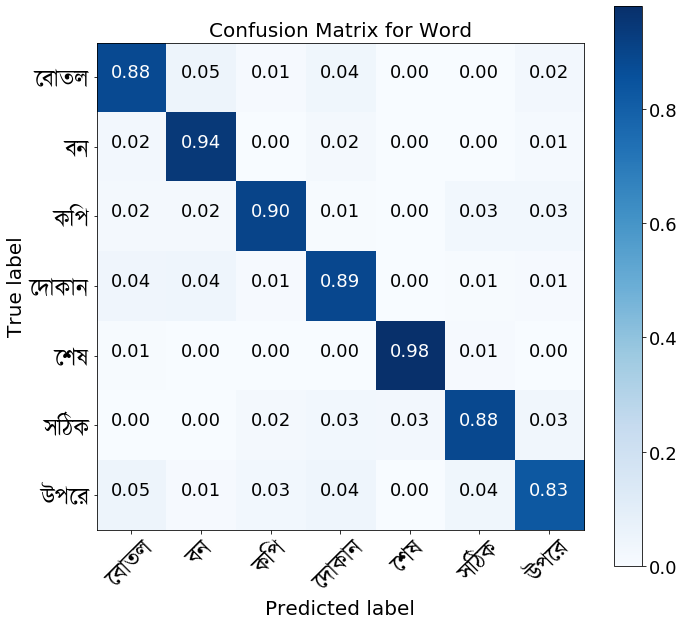

In [10]:
class_names=['েবাতল','বন','কিপ','েদাকান','েশষ','সিঠক','উপের']
cnf_matrix=confusion_matrix(y_test,y_pred)
np.set_printoptions(precision=2)
plt.figure()
plot_cnf_mat(cnf_matrix,classes=class_names,title='Confusion Matrix for Word')
plt.show()